## 1. Importing required libraries

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.patches as patches

2023-12-21 10:04:41.294984: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 10:04:41.295021: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 10:04:41.295847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 10:04:41.393185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 10:04:42.330692: W tensorflow/compiler/

In [2]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2023-12-21 10:04:43.477091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 10:04:43.477134: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 10:04:43.477180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 10:04:43.482423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 10:04:44.208855: W tensorflow/compiler/

## 2. Loading the dataset

In [3]:
train_images_folder = "./dataset/train/images"
test_images_folder = "./dataset/test/images"

train_annotations_folder = "./dataset/train/annotations"
test_annotations_folder = "./dataset/test/annotations"

In [4]:
m_train = len(os.listdir(train_images_folder))
m_test = len(os.listdir(test_images_folder))

max_train_images_per_class = 4800
max_test_images_per_class = 800

num_classes = 10

# reading an image to figure out the dimensions 
img = cv2.imread(f"./dataset/train/images/0.png", cv2.IMREAD_GRAYSCALE)

h,w = img.shape

# Preallocate memory for the images and labels
train_images = np.empty((max_train_images_per_class * 10, h, w), dtype=np.float32)
train_labels = np.empty((max_train_images_per_class * 10, num_classes+4 ), dtype=np.float32)
test_images = np.empty((max_test_images_per_class * 10, h, w), dtype=np.float32)
test_labels = np.empty((max_test_images_per_class * 10, num_classes+4), dtype=np.float32)

print(f"Train data size: {max_train_images_per_class * 10}  |  Test data size: {max_test_images_per_class * 10}")

class_counts = {}

train_count = 0
# loading the train data (taking only 3000 images per class)
for i in range(m_train):
    
    if train_count == max_train_images_per_class * 10:
        print(f'Loaded {max_train_images_per_class} train images per class')
        break
    
    # reading the annotation to get labels
    with open(f"./dataset/train/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))

    
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_train_images_per_class:

        # reading the image
        img = cv2.imread(f"./dataset/train/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image and store it
        train_images[train_count] = img / 255

        # One-hot encode the label
        one_hot_label = np.eye(num_classes)[label]
        
        # bounding box coordinates
        bbox_coordinates = np.array([x_min/w , y_min/h , x_max/w , y_max/h])

        # Concatenate one_hot_label and bbox_coordinates and store it
        train_labels[train_count] = np.concatenate((bbox_coordinates, one_hot_label))
        
        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        train_count += 1


class_counts = {}

test_count = 0
# loading the test data (taking only 500 images per class)
for i in range(m_test):

    if test_count == max_test_images_per_class * 10:
        print(f'Loaded {max_test_images_per_class} test images per class')
        break
        
    # reading the annotation to get labels
    with open(f"./dataset/test/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))
        
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_test_images_per_class:
        
        # reading the image
        img = cv2.imread(f"./dataset/test/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image
        test_images[test_count] = img / 255

        # One-hot encode the label
        one_hot_label = np.eye(num_classes)[label]
        
        # bounding box coordinates
        bbox_coordinates = np.array([x_min/w , y_min/h , x_max/w , y_max/h])

        # Concatenate one_hot_label and bbox_coordinates and store it
        test_labels[test_count] = np.concatenate((bbox_coordinates, one_hot_label))
        
        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        test_count += 1



Train data size: 48000  |  Test data size: 8000
Loaded 4800 train images per class
Loaded 800 test images per class


In [5]:
# renaming our arrays
X_train = train_images
Y_train = train_labels
X_test = test_images
Y_test = test_labels

print(f" X_train shape: {X_train.shape} \n Y_train shape: {Y_train.shape} \n X_test shape: {X_test.shape} \n Y_test shape: {Y_test.shape}")

 X_train shape: (48000, 80, 80) 
 Y_train shape: (48000, 14) 
 X_test shape: (8000, 80, 80) 
 Y_test shape: (8000, 14)


In [6]:
# Reshape X_train to (24000, 80, 80, 1)
X_train = np.reshape(X_train, (X_train.shape[0], 80, 80, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 80, 80, 1))

print(f" X_train shape: {X_train.shape} \n Y_train shape: {Y_train.shape} \n X_test shape: {X_test.shape} \n Y_test shape: {Y_test.shape}")

 X_train shape: (48000, 80, 80, 1) 
 Y_train shape: (48000, 14) 
 X_test shape: (8000, 80, 80, 1) 
 Y_test shape: (8000, 14)


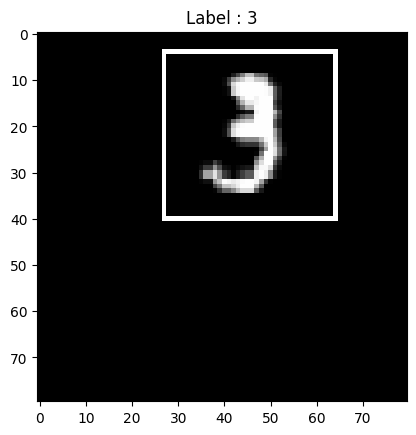

In [7]:
ind = 10

img = (X_train[ind,:]*255)

xmin,ymin,xmax,ymax = Y_train[ind,:4]
label = np.argmax(Y_train[ind,4:])

xmin = int(xmin * w)
xmax = int(xmax * w)
ymin = int(ymin * h)
ymax = int(ymax * h)


bbox = cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)

plt.imshow(bbox , cmap='gray')
plt.title(f"Label : {label}")
plt.show()

## Convolutional Model

In [9]:
def convolutional_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(C1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(C2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C3)
    
    F = tf.keras.layers.Flatten()(P3)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(F)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [10]:
conv_model = convolutional_model((80, 80,1))
conv_model.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 16)           160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 10, 10, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 10, 32)           4640      ['max_pooling2d[0][0]']   

2023-12-20 10:59:59.738801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 10:59:59.760987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 10:59:59.761158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
Y_train_bbox = Y_train[:, :4]
Y_train_class = Y_train[:, 4:]

Y_test_bbox = Y_test[:, :4]
Y_test_class = Y_test[:, 4:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, {"bbox_output": Y_train_bbox, "class_output": Y_train_class})).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, {"bbox_output": Y_test_bbox, "class_output": Y_test_class})).batch(64)


2023-12-21 10:05:27.659966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 10:05:27.681808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 10:05:27.681983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

2023-12-20 11:00:03.590383: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1228800000 exceeds 10% of free system memory.


Epoch 1/100


2023-12-20 11:00:05.100902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-20 11:00:05.819108: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f51e4024e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 11:00:05.819148: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-12-20 11:00:05.823902: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 11:00:05.898508: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 6s 5ms/step - loss: 1.3041 - bbox_output_loss: 0.0129 - class_output_loss: 1.2913 - bbox_output_accuracy: 0.8550 - class_output_accuracy: 0.5454 - val_loss: 5.8103 - val_bbox_output_loss: 0.0152 - val_class_output_loss: 5.7950 - val_bbox_output_accuracy: 0.8526 - val_class_output_accuracy: 0.1534
Epoch 2/100
750/750 [==============================] - 3s 5ms/step - loss: 0.6875 - bbox_output_loss: 0.0078 - class_output_loss: 0.6798 - bbox_output_accuracy: 0.8717 - class_output_accuracy: 0.7797 - val_loss: 3.3966 - val_bbox_output_loss: 0.0088 - val_class_output_loss: 3.3878 - val_bbox_output_accuracy: 0.8725 - val_class_output_accuracy: 0.2754
Epoch 3/100
750/750 [==============================] - 4s 5ms/step - loss: 0.5140 - bbox_output_loss: 0.0056 - class_output_loss: 0.5084 - bbox_output_accuracy: 0.8971 - class_output_accuracy: 0.8351 - val_loss: 2.4047 - val_bbox_output_loss: 0.0062 - val_class_output_loss: 2.3985 - val_bbox_output_accura

In [14]:
def plot_metrics(history):
    # The history.history["loss"] entry is a dictionary with as many values as epochs that the
    # model was trained on. 
    df_loss_acc = pd.DataFrame(history.history)
    df_loss= df_loss_acc[['bbox_output_loss','val_bbox_output_loss']]
    df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
    df_acc= df_loss_acc[['bbox_output_accuracy','val_bbox_output_accuracy']]
    df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
    
    df_loss_class= df_loss_acc[['class_output_loss','val_class_output_loss']]
    df_loss_class.rename(columns={'class_output_loss':'train classfication loss','val_class_output_loss':'validation classification loss'},inplace=True)
    df_acc_class= df_loss_acc[['class_output_accuracy','val_class_output_accuracy']]
    df_acc_class.rename(columns={'class_output_accuracy':'train classification accuracy','val_class_output_accuracy':'validation classification accuracy'},inplace=True)
    
    
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
    
    # Plot loss on the first subplot
    df_loss.plot(title='Model loss Localization', ax=axs[0][0])
    axs[0][0].set(xlabel='Epoch', ylabel='Loss')
    
    # Plot accuracy on the second subplot
    df_acc.plot(title='Model Accuracy Localization', ax=axs[0][1])
    axs[0][1].set(xlabel='Epoch', ylabel='Accuracy')
    
    # Plot classification loss on the third subplot
    df_loss_class.plot(title='Model loss Classification', ax=axs[1][0])
    axs[1][0].set(xlabel='Epoch', ylabel='Loss')
    
    # Plot classification accuracy on the third subplot
    df_acc_class.plot(title='Model Accuracy Classification', ax=axs[1][1])
    axs[1][1].set(xlabel='Epoch', ylabel='Accuracy')
    
    # Display the figure with the subplots
    plt.show()

In [15]:
def predict_and_plot(ind, model):

    # Assuming X_test[ind,:] is your numpy array
    original = X_test[ind,:]*255
    
    # Create a copy of the array
    img = np.copy(original)

    # Reshape the array to 2D if it's grayscale
    if img.shape[-1] == 1:
        img = img.reshape(img.shape[0], img.shape[1])

    # Convert the numpy array to an image
    image = Image.fromarray(img.astype('uint8'))
    # Convert the image into RGB
    rgb_image = image.convert('RGB')

    # Convert the PIL Image back to a numpy array for OpenCV
    rgb_image_cv2 = np.array(rgb_image)

    xmin,ymin,xmax,ymax = Y_test[ind,:4]
    g_truth = np.argmax(Y_test[ind,4:])
    
    xmin = int(xmin * w)
    xmax = int(xmax * w)
    ymin = int(ymin * h)
    ymax = int(ymax * h)
    
    
    cv2.rectangle(rgb_image_cv2, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)
    
    pred_image= np.copy(X_test[ind])
    # Extract the example and add an extra dimension at the start
    pred_image = np.expand_dims(pred_image, axis=0)

    bbox, classs = model.predict(pred_image)

    
    
    xmin,ymin,xmax,ymax = bbox[0]
    label = np.argmax(classs)
    
    xmin = int(xmin * w)
    xmax = int(xmax * w)
    ymin = int(ymin * h)
    ymax = int(ymax * h)

    print(xmin,ymin,xmax,ymax)
    
    cv2.rectangle(rgb_image_cv2, (xmin,ymin), (xmax, ymax), (0,255,0) , 1)    # (pic , start , end , color, thickness)

    # Create a red patch for ground truth
    red_patch = patches.Patch(color='red', label='Ground Truth')
    # Create a green patch for prediction
    green_patch = patches.Patch(color='green', label='Prediction')
    
    plt.imshow(rgb_image_cv2)
    plt.title(f"Ground Truth : {g_truth} Predicted Label : {label}")
    plt.legend(handles=[red_patch, green_patch])
    plt.show()
    

/tmp/ipykernel_59413/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

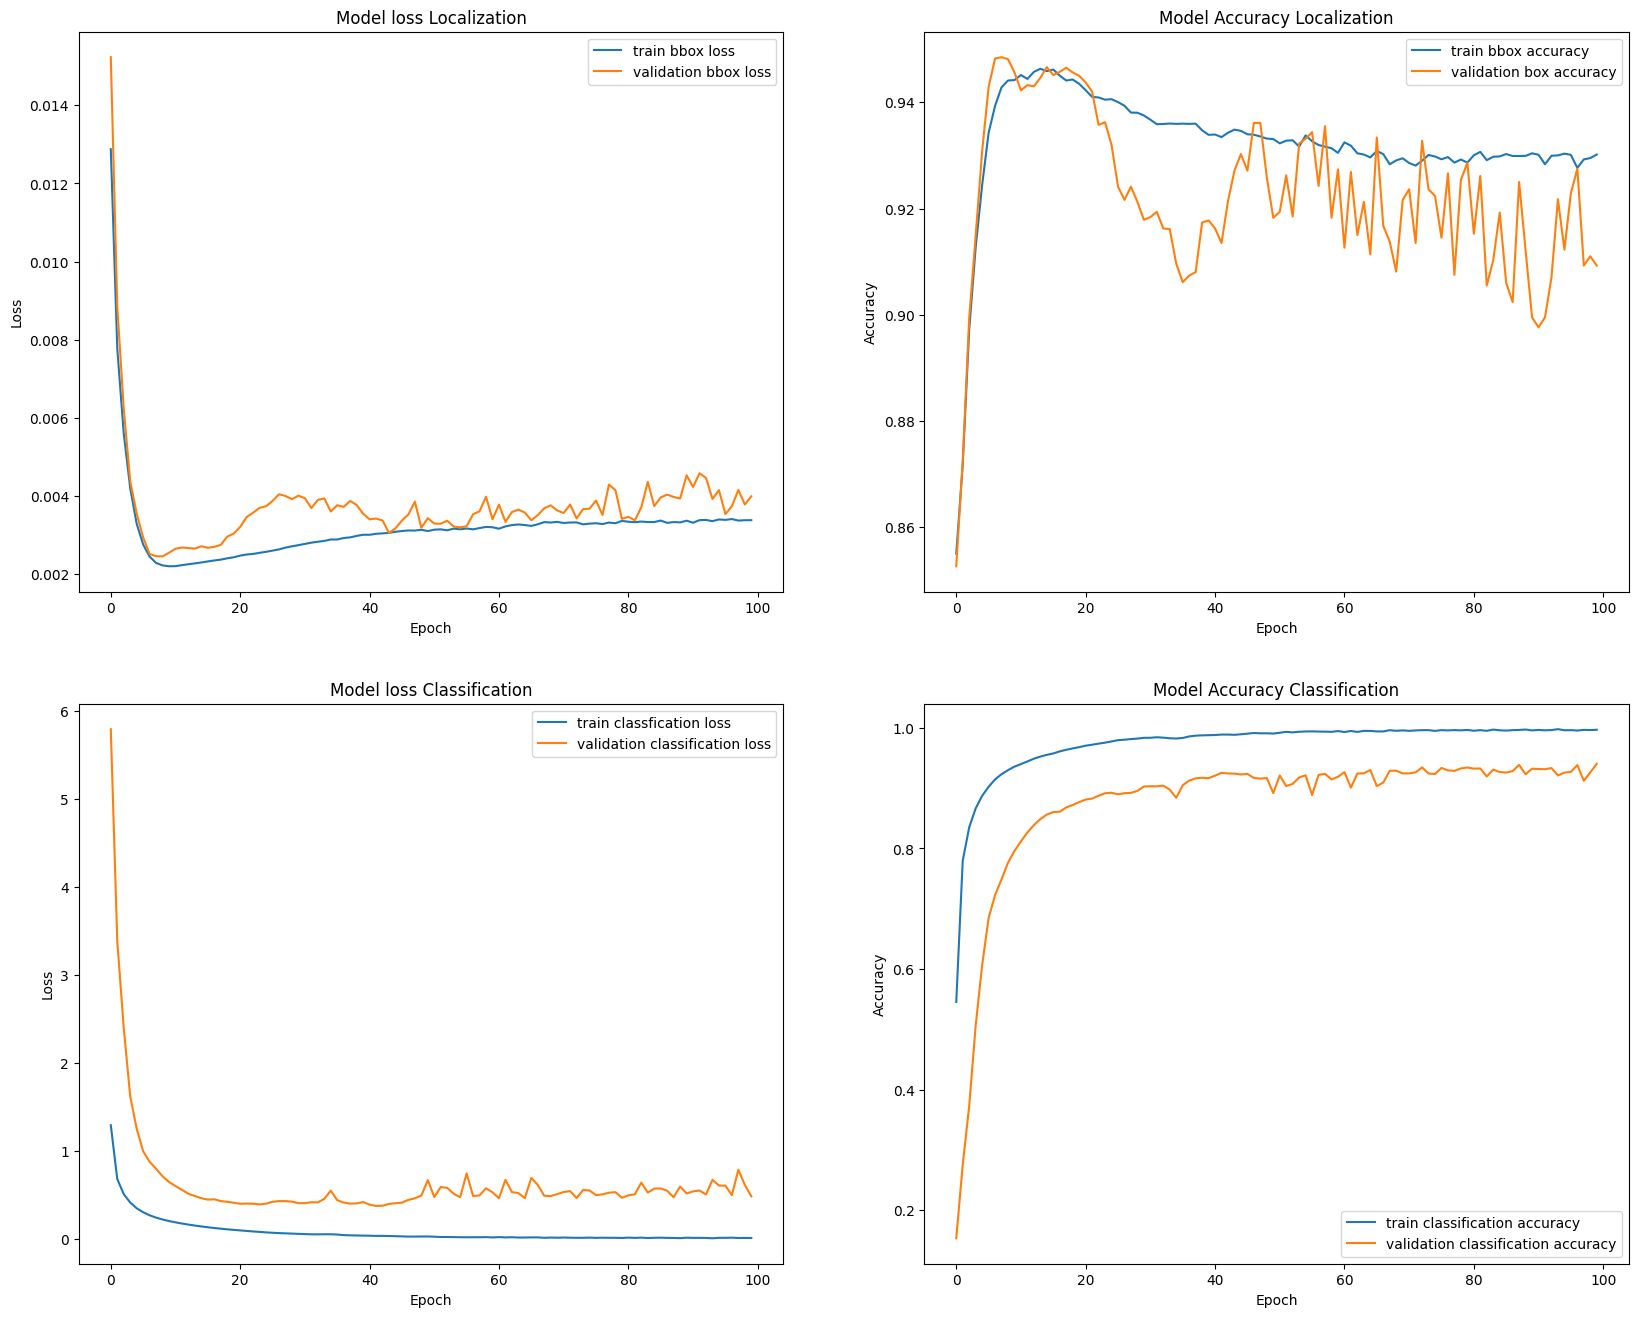

In [15]:
plot_metrics(history)

1/1 [==============================] - 0s 163ms/step
26 43 56 73


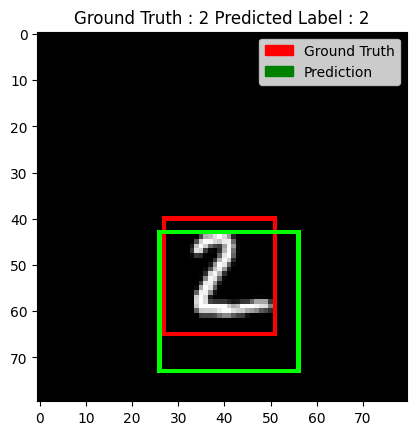

1/1 [==============================] - 0s 14ms/step
38 47 61 69


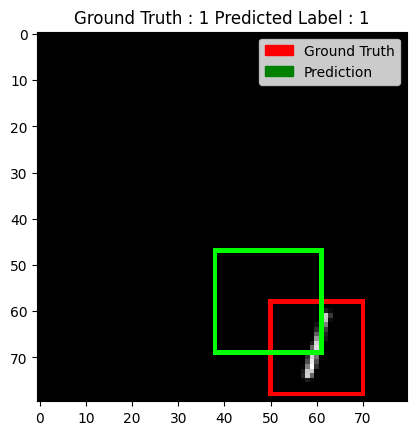

1/1 [==============================] - 0s 13ms/step
20 3 44 26


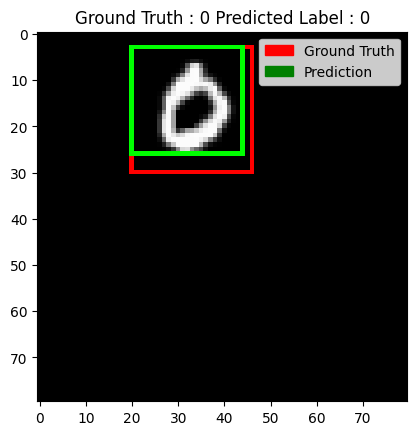

1/1 [==============================] - 0s 14ms/step
36 7 68 38


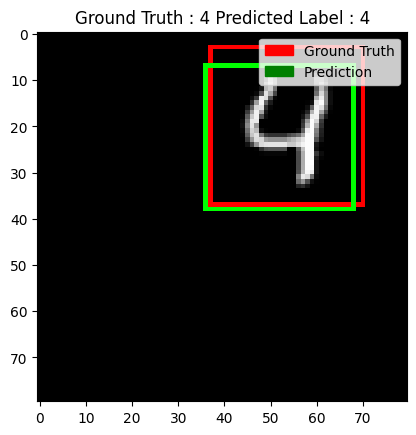

1/1 [==============================] - 0s 15ms/step
21 42 53 73


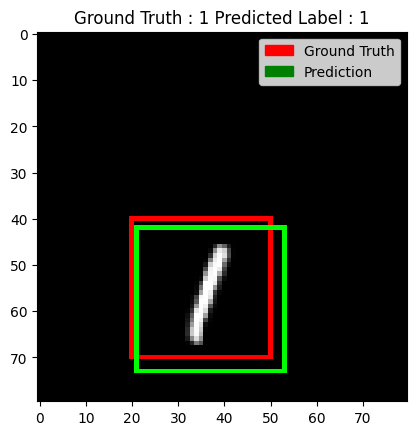

1/1 [==============================] - 0s 14ms/step
15 37 51 73


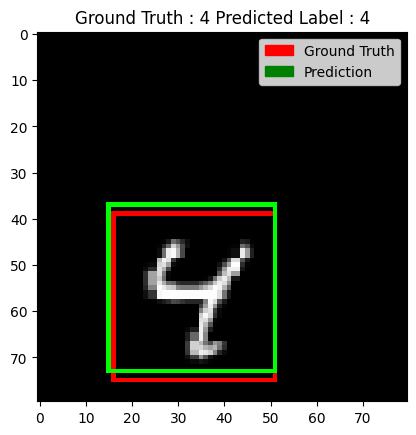

1/1 [==============================] - 0s 13ms/step
47 31 70 54


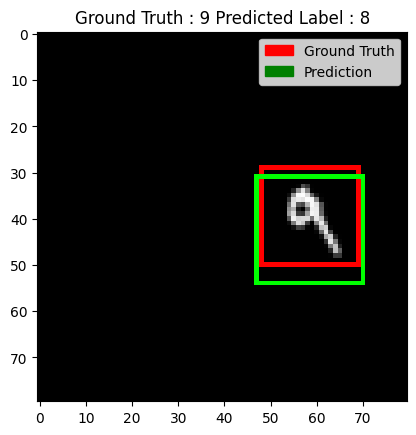

1/1 [==============================] - 0s 13ms/step
45 19 71 45


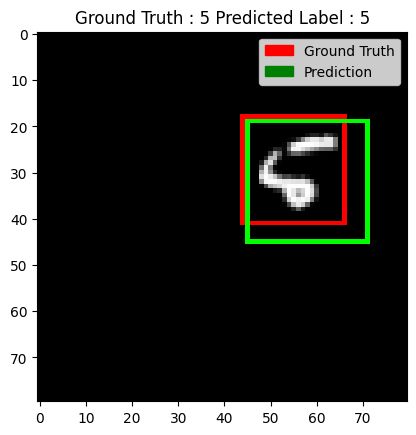

1/1 [==============================] - 0s 13ms/step
3 7 35 39


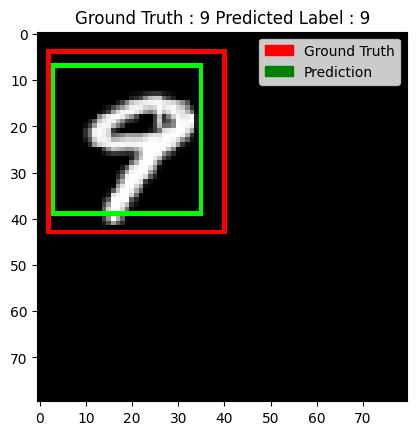

1/1 [==============================] - 0s 16ms/step
33 25 55 47


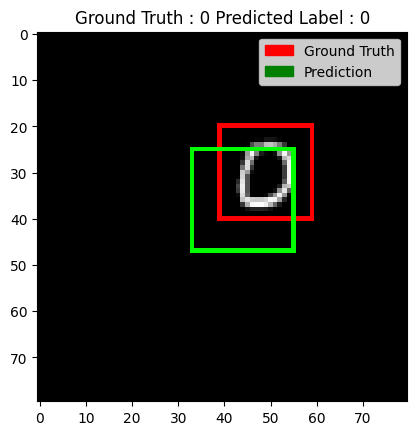

In [16]:
for i in range(10):
    predict_and_plot(1+i,conv_model)

## Defining another Model

In [17]:
def convolutional_model2(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(C1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(C2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C3)
    
    F = tf.keras.layers.Flatten()(P3)

    localization_branch = tf.keras.layers.Dense(64,activation='relu')(F)
    classification_branch = tf.keras.layers.Dense(64,activation='relu')(F)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(localization_branch)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(classification_branch)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [18]:
conv_model2 = convolutional_model2((80, 80,1))
conv_model2.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 80, 80, 16)           160       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 16)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 10, 10, 32)           4640      ['max_pooling2d_3[0][0]'

In [19]:
history2 = conv_model2.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
750/750 [==============================] - 6s 6ms/step - loss: 1.3233 - bbox_output_loss: 0.0070 - class_output_loss: 1.3163 - bbox_output_accuracy: 0.9117 - class_output_accuracy: 0.5227 - val_loss: 7.1599 - val_bbox_output_loss: 0.0059 - val_class_output_loss: 7.1540 - val_bbox_output_accuracy: 0.9249 - val_class_output_accuracy: 0.1036
Epoch 2/100
750/750 [==============================] - 4s 6ms/step - loss: 0.6963 - bbox_output_loss: 0.0033 - class_output_loss: 0.6930 - bbox_output_accuracy: 0.9346 - class_output_accuracy: 0.7719 - val_loss: 5.4287 - val_bbox_output_loss: 0.0041 - val_class_output_loss: 5.4246 - val_bbox_output_accuracy: 0.9406 - val_class_output_accuracy: 0.1275
Epoch 3/100
750/750 [==============================] - 4s 5ms/step - loss: 0.4934 - bbox_output_loss: 0.0023 - class_output_loss: 0.4911 - bbox_output_accuracy: 0.9467 - class_output_accuracy: 0.8423 - val_loss: 3.7165 - val_bbox_output_loss: 0.0025 - val_class_output_loss: 3.7140 - val_bbox_o

/tmp/ipykernel_59413/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

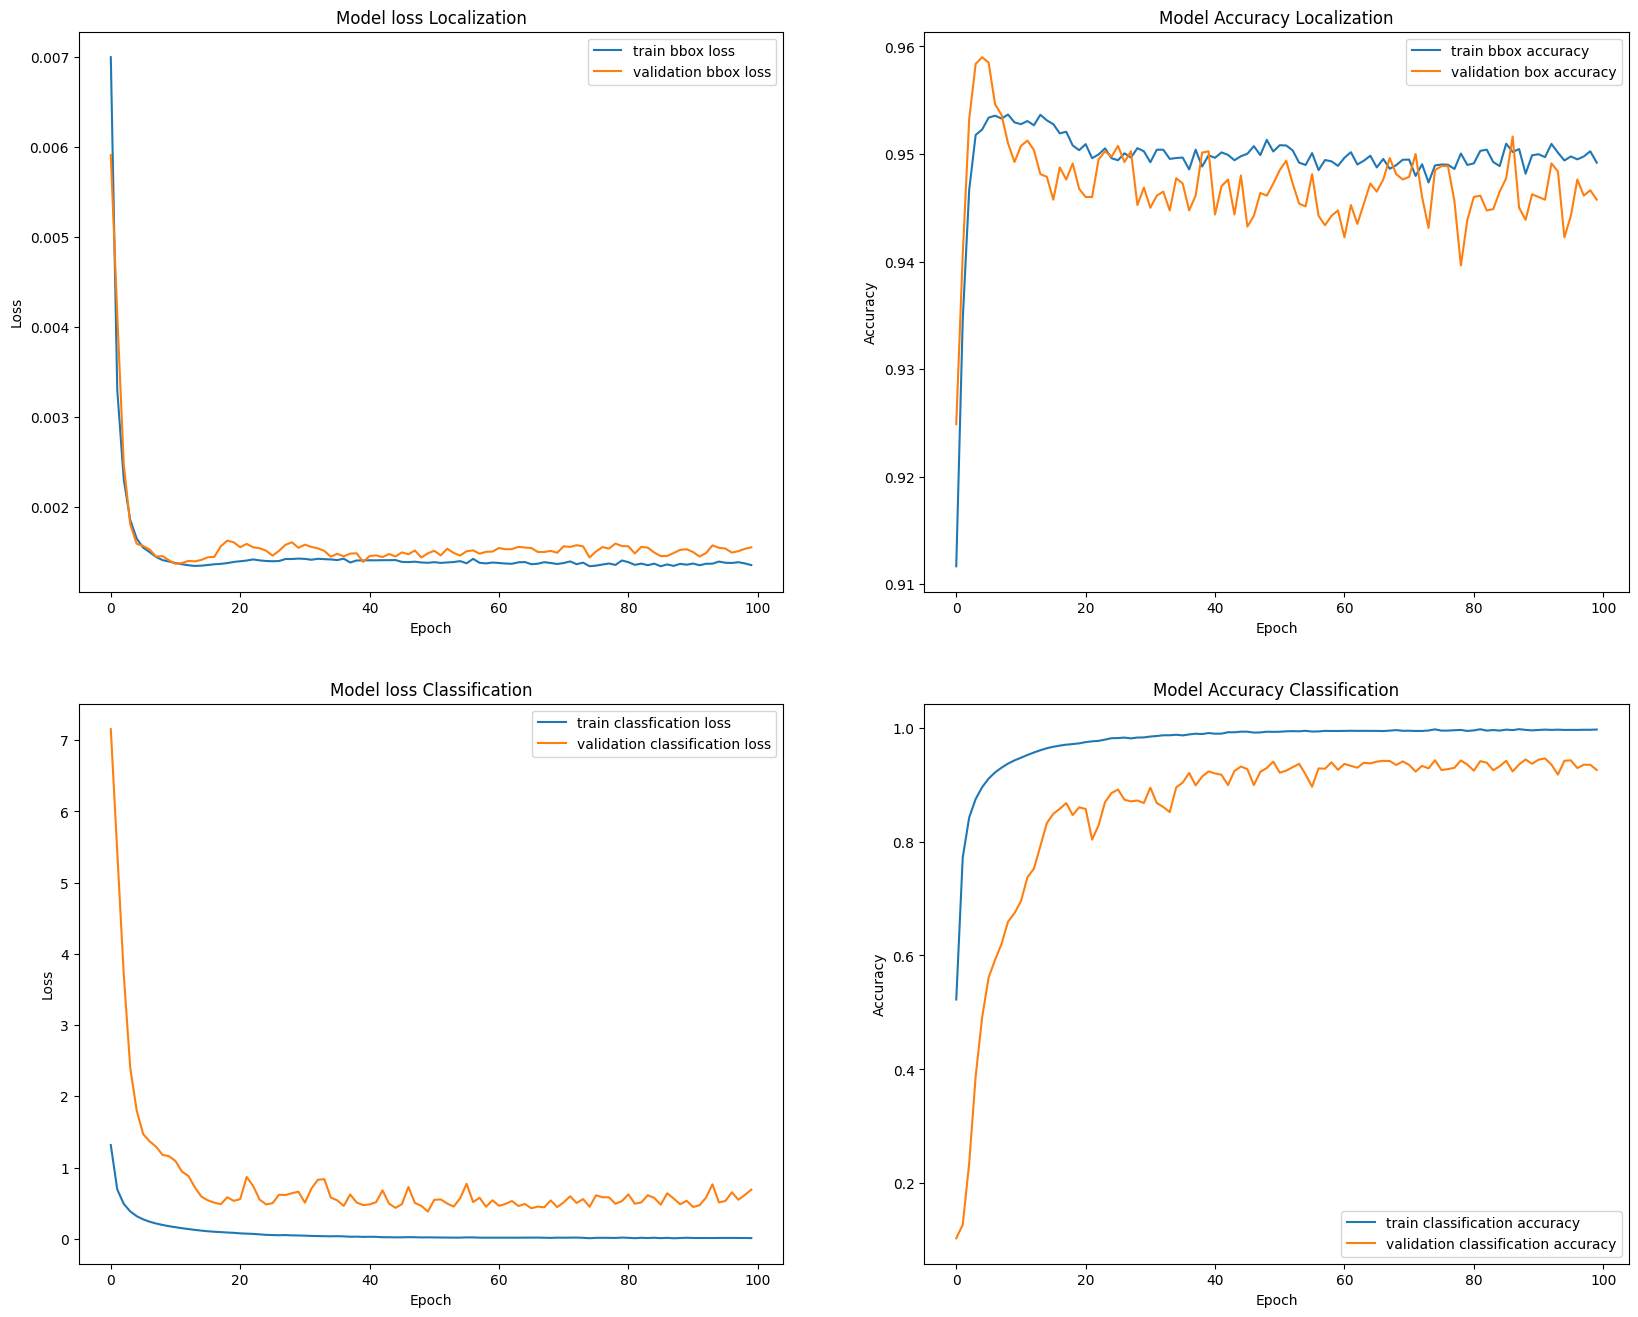

In [20]:
plot_metrics(history2)

1/1 [==============================] - 0s 53ms/step
22 38 52 68


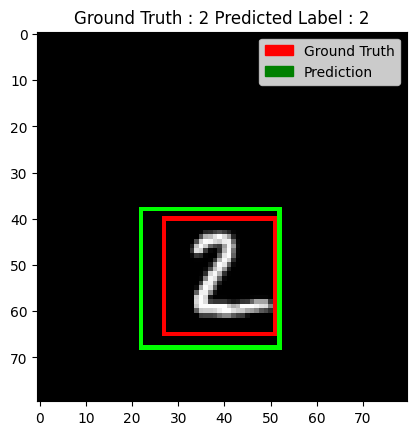

1/1 [==============================] - 0s 13ms/step
48 52 70 74


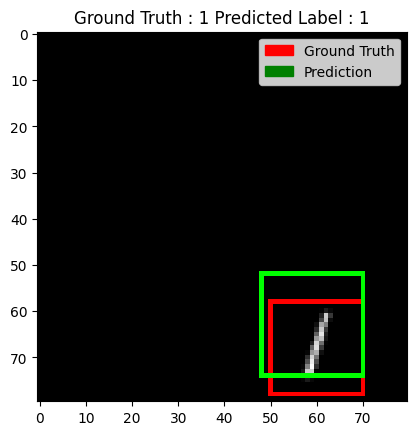

1/1 [==============================] - 0s 13ms/step
20 2 49 30


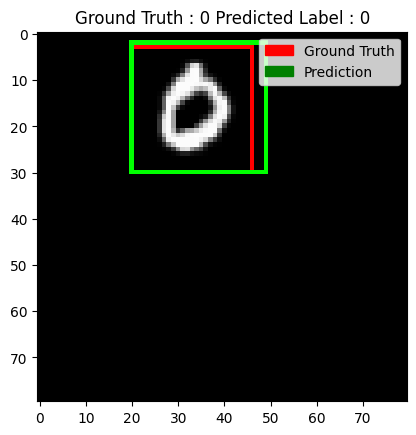

1/1 [==============================] - 0s 13ms/step
38 4 68 34


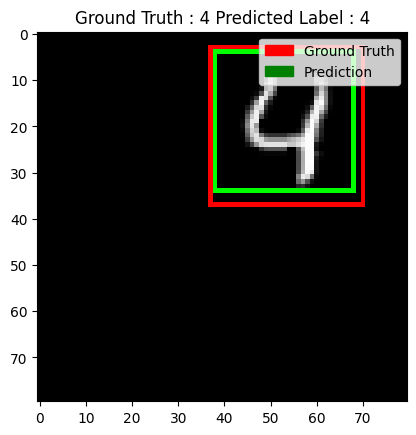

1/1 [==============================] - 0s 12ms/step
23 41 56 74


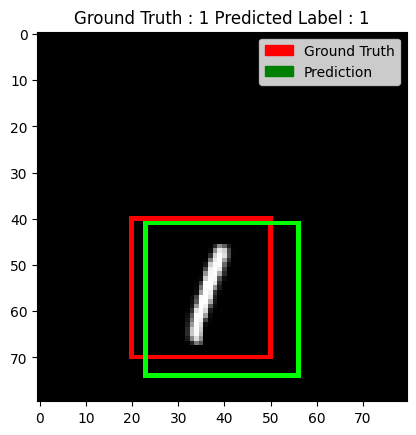

1/1 [==============================] - 0s 12ms/step
18 39 51 72


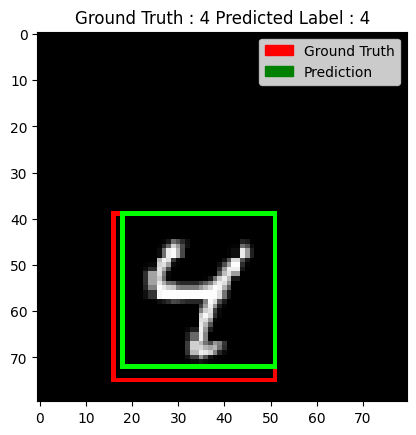

1/1 [==============================] - 0s 12ms/step
47 24 71 48


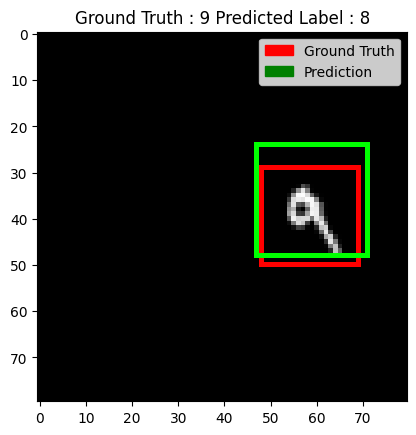

1/1 [==============================] - 0s 14ms/step
40 13 67 40


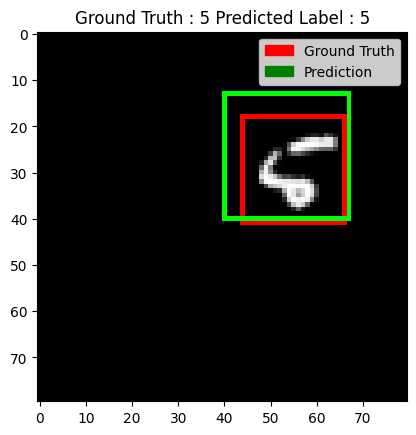

1/1 [==============================] - 0s 12ms/step
3 4 38 40


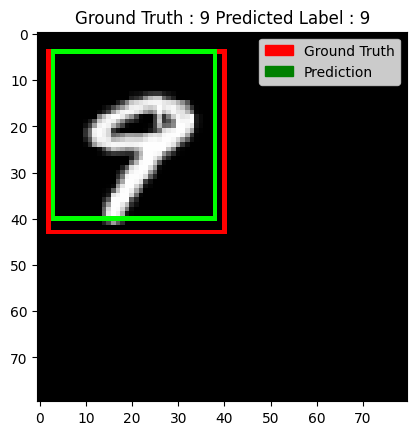

1/1 [==============================] - 0s 12ms/step
33 21 56 44


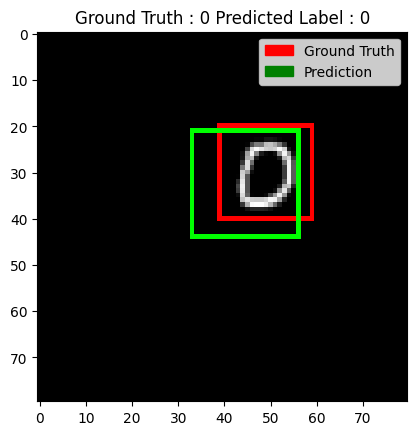

In [21]:
for i in range(10):
    predict_and_plot(1+i,conv_model2)

## Another Model

In [22]:
def convolutional_model3(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(6,6),strides=6,padding='same')(C1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(C2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C3)

    C4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(P3)
    P4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C4)
    
    F = tf.keras.layers.Flatten()(P4)

    l_b1 = tf.keras.layers.Dense(32,activation='relu')(F)
    c_b1 = tf.keras.layers.Dense(32,activation='relu')(F)

    l_b2 = tf.keras.layers.Dense(16,activation='relu')(l_b1)
    c_b2 = tf.keras.layers.Dense(16,activation='relu')(c_b1)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(l_b2)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(c_b2)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [23]:
conv_model3 = convolutional_model3((80, 80,1))
conv_model3.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 80, 80, 16)           160       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)           0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 14, 14, 32)           4640      ['max_pooling2d_6[0][0]'

In [24]:
history3 = conv_model3.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
750/750 [==============================] - 6s 6ms/step - loss: 1.4024 - bbox_output_loss: 0.0083 - class_output_loss: 1.3941 - bbox_output_accuracy: 0.9033 - class_output_accuracy: 0.4743 - val_loss: 8.3745 - val_bbox_output_loss: 0.0093 - val_class_output_loss: 8.3652 - val_bbox_output_accuracy: 0.8164 - val_class_output_accuracy: 0.1000
Epoch 2/100
750/750 [==============================] - 4s 6ms/step - loss: 0.7447 - bbox_output_loss: 0.0050 - class_output_loss: 0.7397 - bbox_output_accuracy: 0.9040 - class_output_accuracy: 0.7518 - val_loss: 5.8612 - val_bbox_output_loss: 0.0048 - val_class_output_loss: 5.8564 - val_bbox_output_accuracy: 0.9021 - val_class_output_accuracy: 0.1185
Epoch 3/100
750/750 [==============================] - 4s 6ms/step - loss: 0.4648 - bbox_output_loss: 0.0035 - class_output_loss: 0.4612 - bbox_output_accuracy: 0.9190 - class_output_accuracy: 0.8528 - val_loss: 3.4087 - val_bbox_output_loss: 0.0037 - val_class_output_loss: 3.4050 - val_bbox_o

/tmp/ipykernel_59413/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

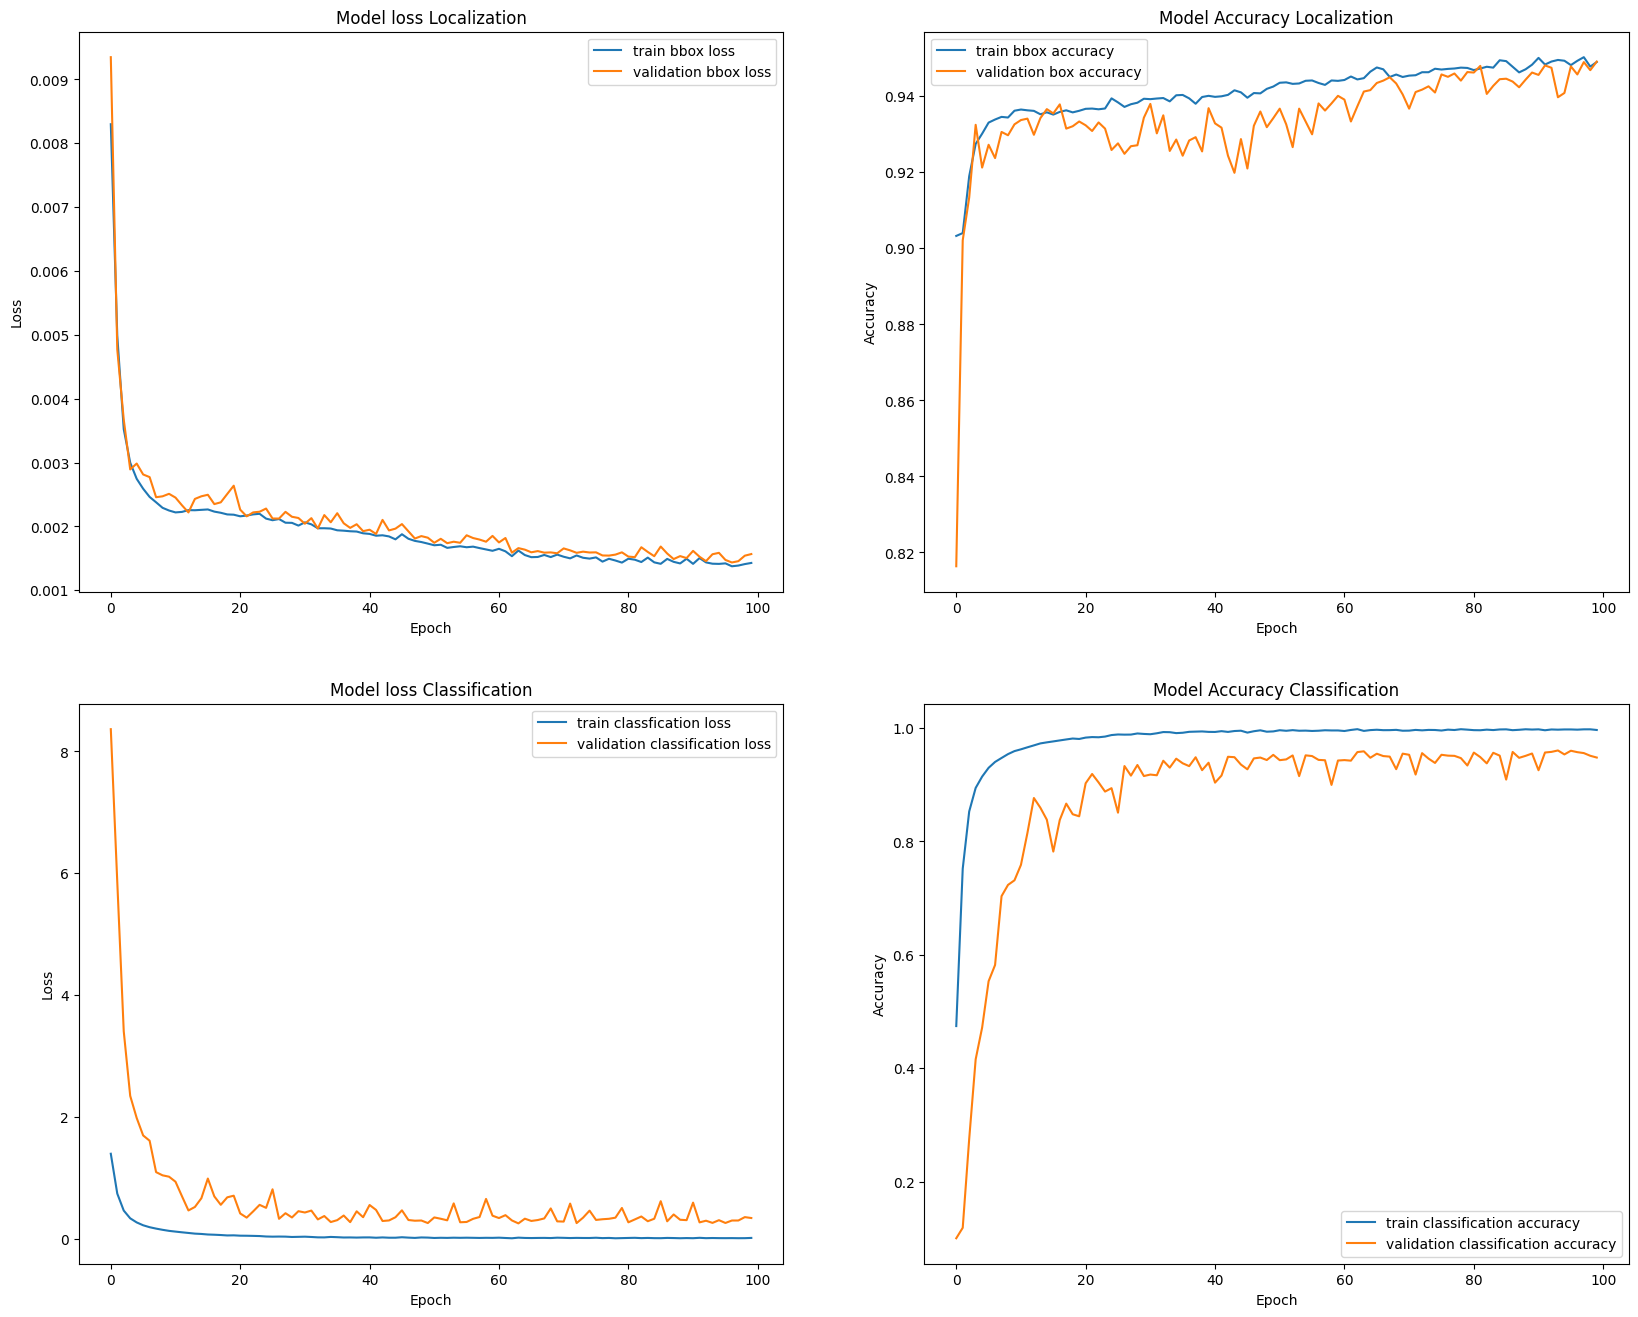

In [25]:
plot_metrics(history3)

1/1 [==============================] - 0s 101ms/step
27 37 58 69


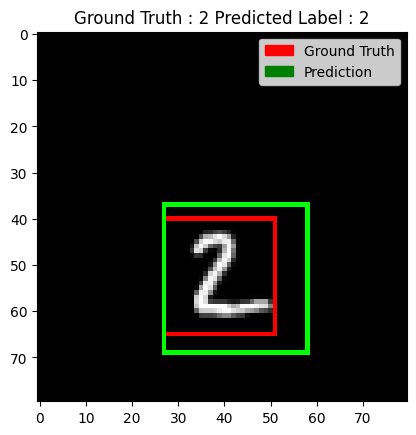

1/1 [==============================] - 0s 12ms/step
52 56 73 77


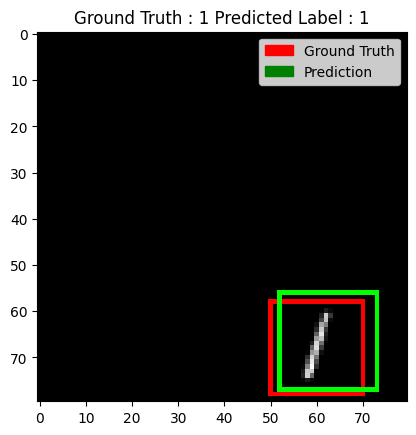

1/1 [==============================] - 0s 12ms/step
21 2 46 27


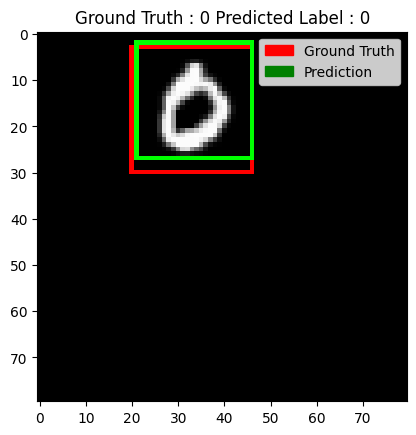

1/1 [==============================] - 0s 12ms/step
38 4 71 36


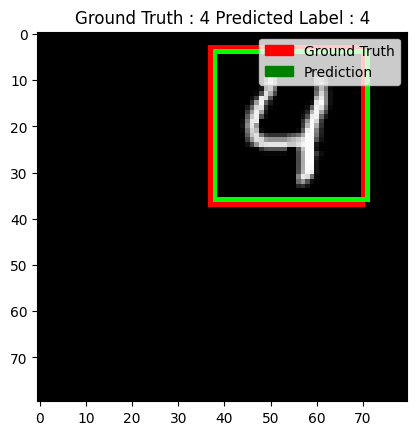

1/1 [==============================] - 0s 13ms/step
20 44 47 70


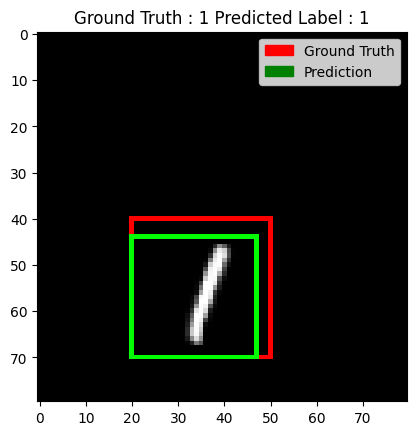

1/1 [==============================] - 0s 14ms/step
21 40 54 72


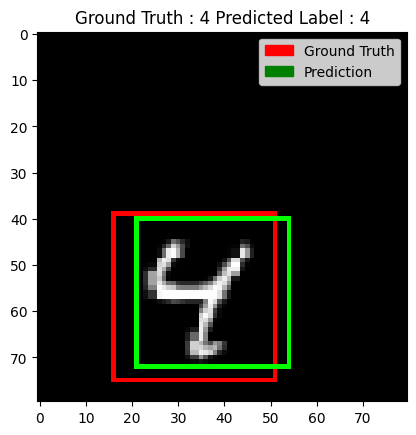

1/1 [==============================] - 0s 13ms/step
42 23 71 52


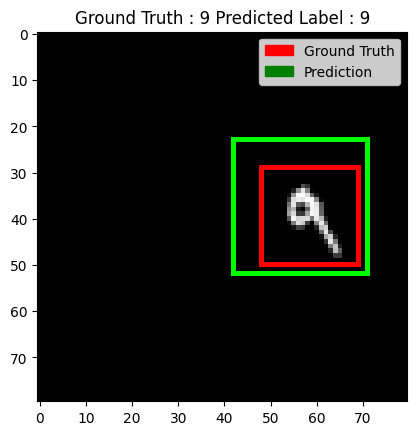

1/1 [==============================] - 0s 13ms/step
39 19 63 43


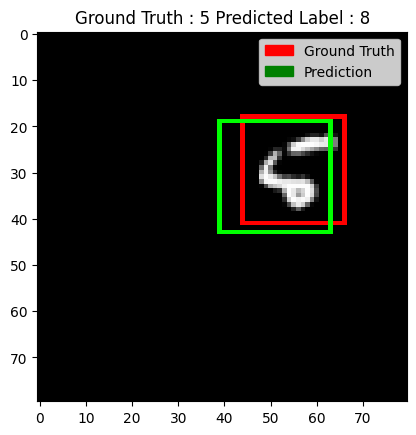

1/1 [==============================] - 0s 12ms/step
2 5 39 42


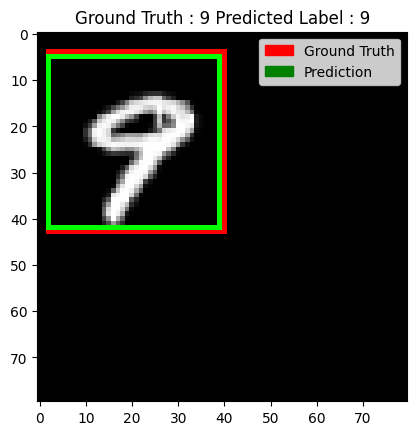

1/1 [==============================] - 0s 15ms/step
36 21 57 42


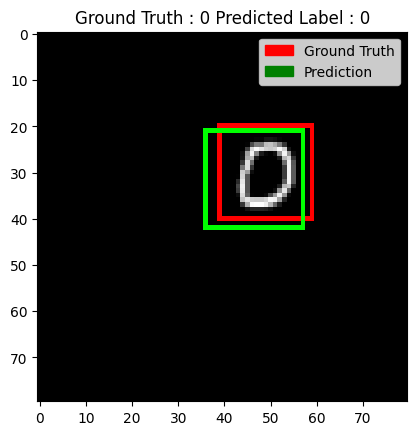

In [26]:
for i in range(10):
    predict_and_plot(1+i,conv_model3)

## Another Model

In [27]:
def convolutional_model4(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    D1 = tf.keras.layers.Dropout(0.2)(C1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(6,6),strides=6,padding='same')(D1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    D2 = tf.keras.layers.Dropout(0.2)(C2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(D2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    D3 = tf.keras.layers.Dropout(0.2)(C3)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D3)

    C4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(P3)
    D4 = tf.keras.layers.Dropout(0.2)(C4)
    P4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D4)
    
    F = tf.keras.layers.Flatten()(P4)

    l_b1 = tf.keras.layers.Dense(32,activation='relu')(F)
    l_b1_d = tf.keras.layers.Dropout(0.2)(l_b1)
    
    c_b1 = tf.keras.layers.Dense(32,activation='relu')(F)
    c_b1_d = tf.keras.layers.Dropout(0.2)(c_b1)

    l_b2 = tf.keras.layers.Dense(16,activation='relu')(l_b1_d)
    c_b2 = tf.keras.layers.Dense(16,activation='relu')(c_b1_d)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(l_b2)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(c_b2)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [28]:
conv_model4 = convolutional_model4((80, 80,1))
conv_model4.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 80, 80, 16)           160       ['input_4[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 80, 80, 16)           0         ['conv2d_10[0][0]']           
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 16)           0         ['dropout[0][0]']             
 ng2D)                                                                                      

In [29]:
history4 = conv_model4.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100


2023-12-20 11:20:19.198250: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


750/750 [==============================] - 8s 8ms/step - loss: 1.6996 - bbox_output_loss: 0.0152 - class_output_loss: 1.6844 - bbox_output_accuracy: 0.8531 - class_output_accuracy: 0.3226 - val_loss: 2.2009 - val_bbox_output_loss: 0.0188 - val_class_output_loss: 2.1821 - val_bbox_output_accuracy: 0.8406 - val_class_output_accuracy: 0.1945
Epoch 2/100
750/750 [==============================] - 5s 7ms/step - loss: 1.1258 - bbox_output_loss: 0.0079 - class_output_loss: 1.1178 - bbox_output_accuracy: 0.8774 - class_output_accuracy: 0.5586 - val_loss: 2.1719 - val_bbox_output_loss: 0.0112 - val_class_output_loss: 2.1606 - val_bbox_output_accuracy: 0.8940 - val_class_output_accuracy: 0.2661
Epoch 3/100
750/750 [==============================] - 5s 7ms/step - loss: 0.8030 - bbox_output_loss: 0.0071 - class_output_loss: 0.7959 - bbox_output_accuracy: 0.8714 - class_output_accuracy: 0.7127 - val_loss: 2.4268 - val_bbox_output_loss: 0.0103 - val_class_output_loss: 2.4165 - val_bbox_output_accura

/tmp/ipykernel_59413/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

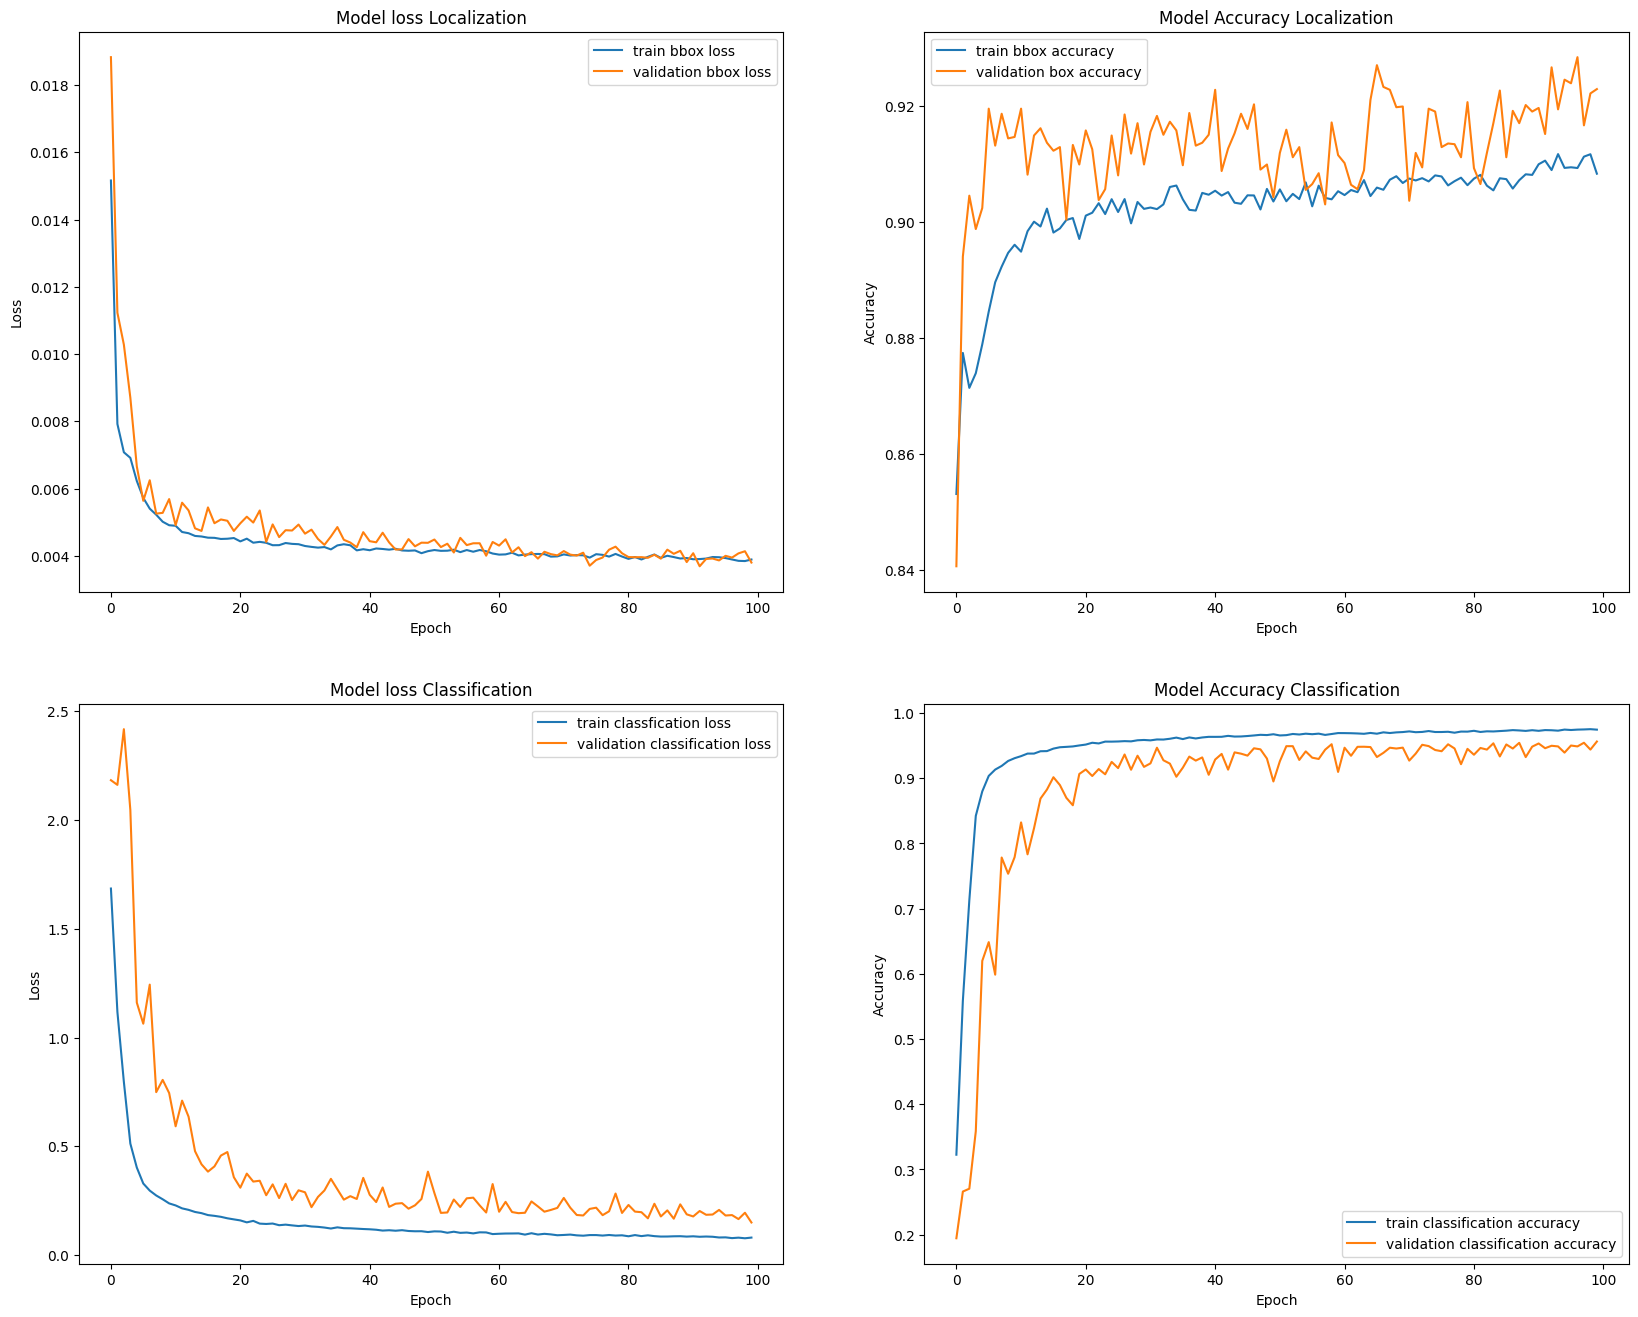

In [30]:
plot_metrics(history4)

1/1 [==============================] - 0s 74ms/step
22 35 51 64


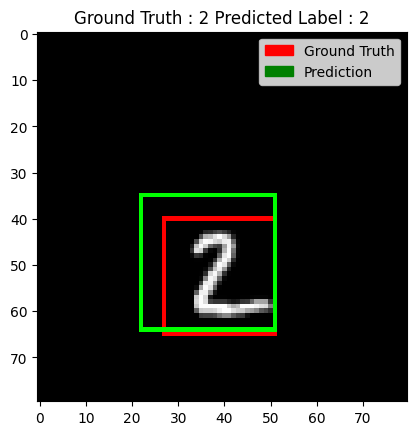

1/1 [==============================] - 0s 13ms/step
37 44 64 70


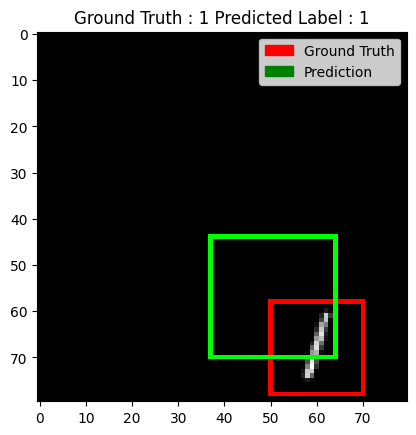

1/1 [==============================] - 0s 13ms/step
21 5 47 32


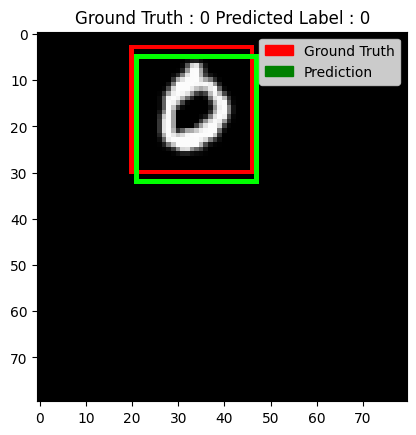

1/1 [==============================] - 0s 12ms/step
42 4 69 32


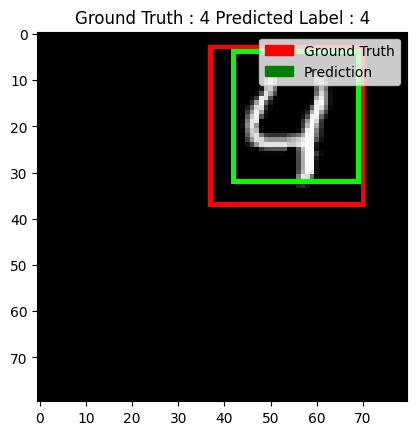

1/1 [==============================] - 0s 12ms/step
20 40 50 70


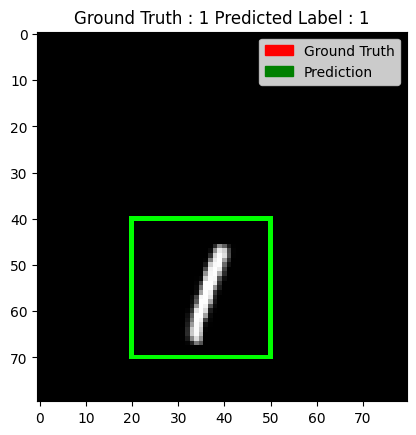

1/1 [==============================] - 0s 13ms/step
20 40 51 71


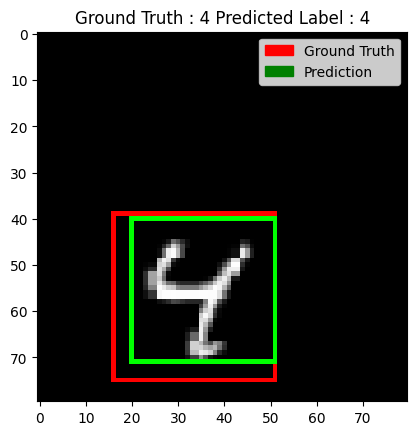

1/1 [==============================] - 0s 14ms/step
39 28 65 54


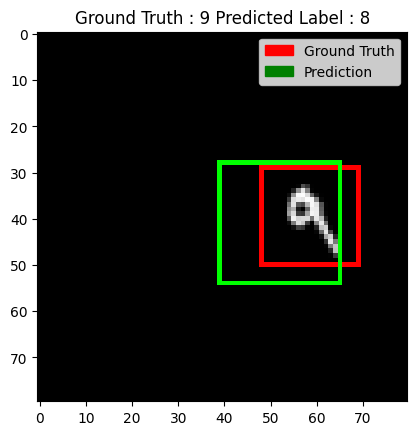

1/1 [==============================] - 0s 12ms/step
32 18 62 48


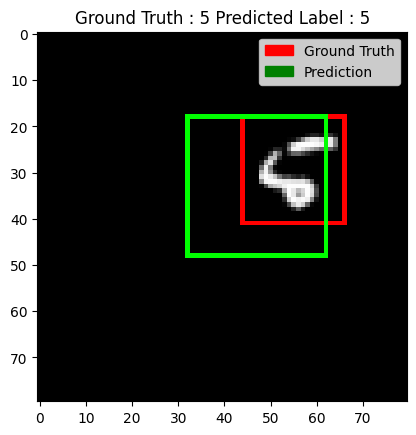

1/1 [==============================] - 0s 13ms/step
9 13 37 42


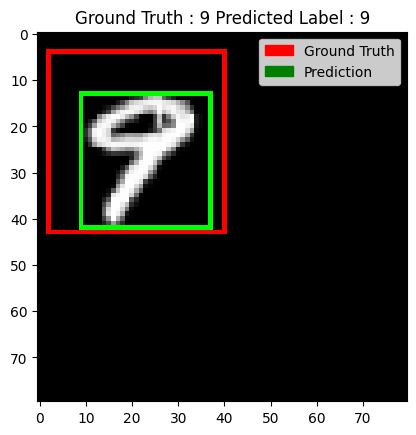

1/1 [==============================] - 0s 13ms/step
30 16 59 45


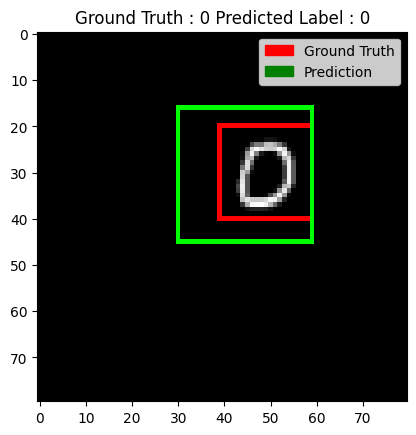

In [31]:
for i in range(10):
    predict_and_plot(1+i,conv_model4)

In [43]:
def convolutional_model5(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    D1 = tf.keras.layers.Dropout(0.2)(C1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    D2 = tf.keras.layers.Dropout(0.2)(C2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    D3 = tf.keras.layers.Dropout(0.2)(C3)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D3)

    C4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(P3)
    D4 = tf.keras.layers.Dropout(0.2)(C4)
    P4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D4)

    C5 = tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(P4)
    D5 = tf.keras.layers.Dropout(0.2)(C5)
    P5 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D5)

    C6 = tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(P5)
    D6 = tf.keras.layers.Dropout(0.2)(C6)
    P6 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D6)
    
    F = tf.keras.layers.Flatten()(P6)

    l_b1 = tf.keras.layers.Dense(128,activation='relu')(F)
    l_b1_d = tf.keras.layers.Dropout(0.2)(l_b1)
    
    c_b1 = tf.keras.layers.Dense(128,activation='relu')(F)
    c_b1_d = tf.keras.layers.Dropout(0.2)(c_b1)

    l_b2 = tf.keras.layers.Dense(64,activation='relu')(l_b1_d)
    c_b2 = tf.keras.layers.Dense(64,activation='relu')(c_b1_d)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(l_b2)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(c_b2)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [44]:
conv_model5 = convolutional_model5((80, 80,1))
conv_model5.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 80, 80, 16)           160       ['input_10[0][0]']            
                                                                                                  
 dropout_43 (Dropout)        (None, 80, 80, 16)           0         ['conv2d_41[0][0]']           
                                                                                                  
 max_pooling2d_41 (MaxPooli  (None, 40, 40, 16)           0         ['dropout_43[0][0]']          
 ng2D)                                                                                      

In [45]:
history5 = conv_model5.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100


2023-12-20 11:42:20.725296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_43/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


750/750 [==============================] - 11s 12ms/step - loss: 1.0043 - bbox_output_loss: 0.0134 - class_output_loss: 0.9909 - bbox_output_accuracy: 0.8795 - class_output_accuracy: 0.6370 - val_loss: 1.7855 - val_bbox_output_loss: 0.0057 - val_class_output_loss: 1.7798 - val_bbox_output_accuracy: 0.9284 - val_class_output_accuracy: 0.3971
Epoch 2/100
750/750 [==============================] - 9s 12ms/step - loss: 0.2208 - bbox_output_loss: 0.0040 - class_output_loss: 0.2167 - bbox_output_accuracy: 0.9145 - class_output_accuracy: 0.9371 - val_loss: 0.9406 - val_bbox_output_loss: 0.0035 - val_class_output_loss: 0.9370 - val_bbox_output_accuracy: 0.9350 - val_class_output_accuracy: 0.7236
Epoch 3/100
750/750 [==============================] - 9s 11ms/step - loss: 0.1401 - bbox_output_loss: 0.0032 - class_output_loss: 0.1369 - bbox_output_accuracy: 0.9200 - class_output_accuracy: 0.9615 - val_loss: 0.5833 - val_bbox_output_loss: 0.0030 - val_class_output_loss: 0.5802 - val_bbox_output_ac

/tmp/ipykernel_59413/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_59413/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

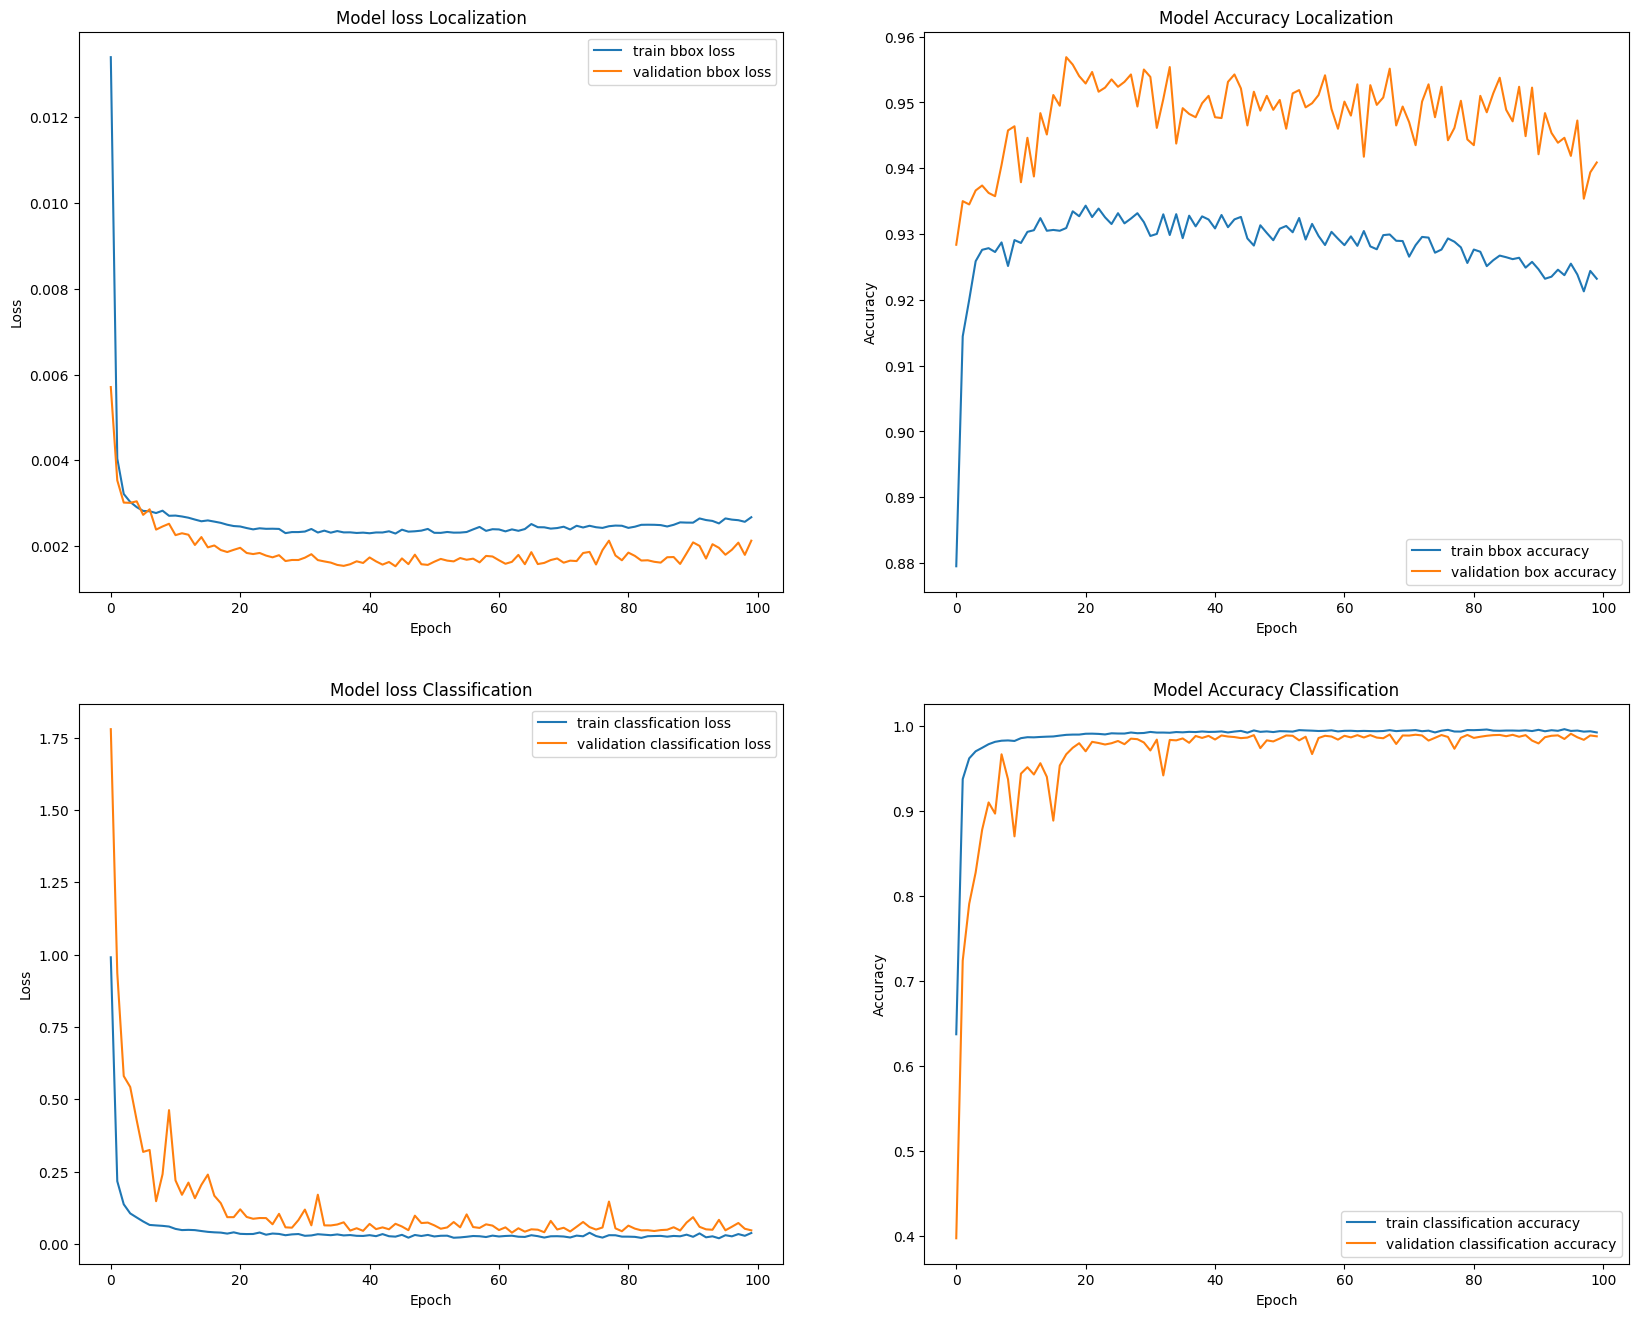

In [46]:
plot_metrics(history5)

1/1 [==============================] - 0s 141ms/step
32 35 60 63


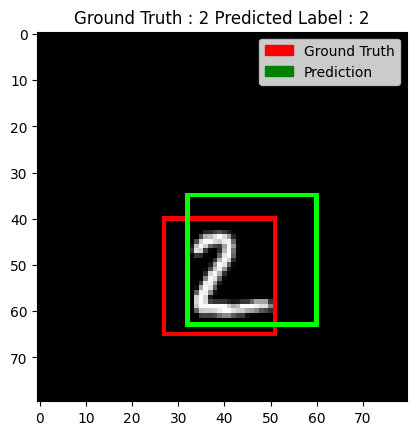

1/1 [==============================] - 0s 14ms/step
46 45 71 71


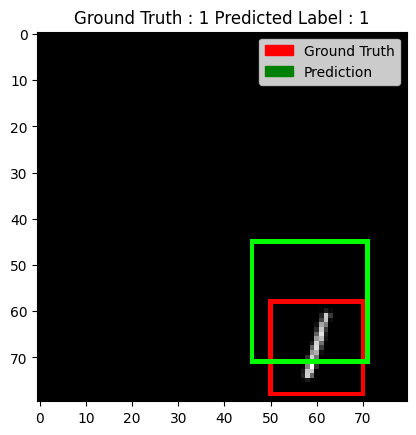

1/1 [==============================] - 0s 14ms/step
20 6 46 31


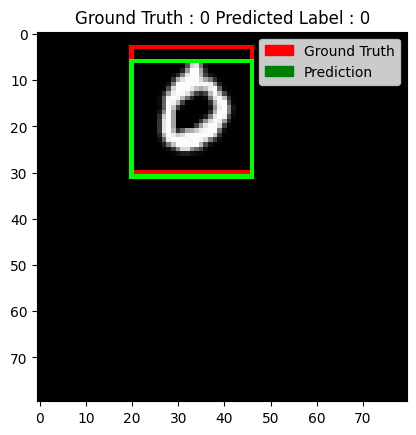

1/1 [==============================] - 0s 13ms/step
39 8 68 37


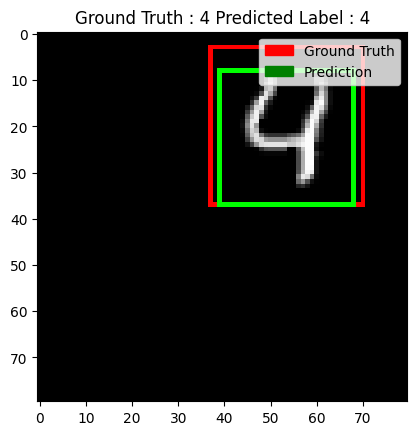

1/1 [==============================] - 0s 14ms/step
18 38 52 72


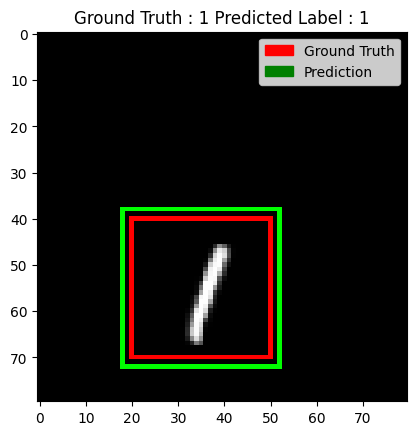

1/1 [==============================] - 0s 13ms/step
16 37 50 71


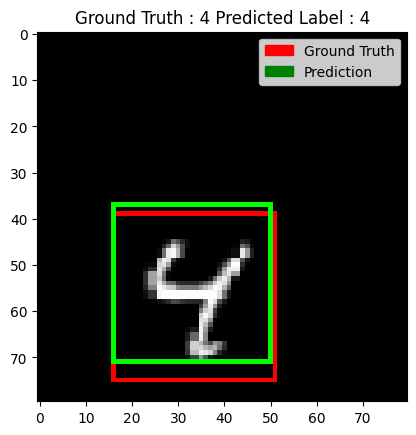

1/1 [==============================] - 0s 13ms/step
44 19 69 44


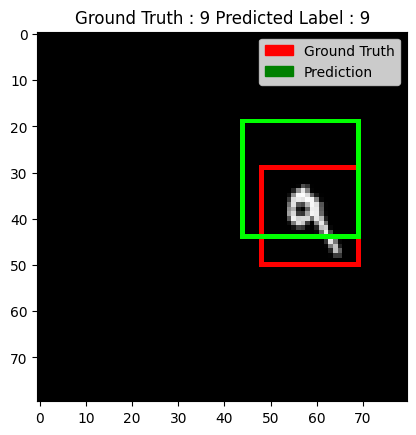

1/1 [==============================] - 0s 13ms/step
38 16 66 45


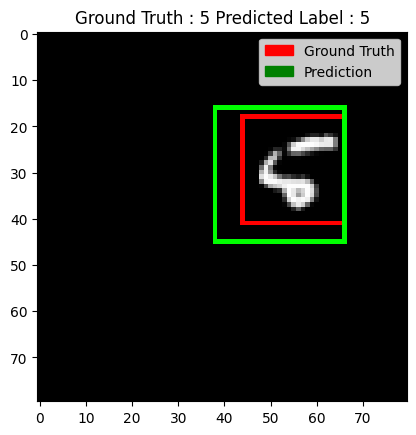

1/1 [==============================] - 0s 13ms/step
7 8 41 42


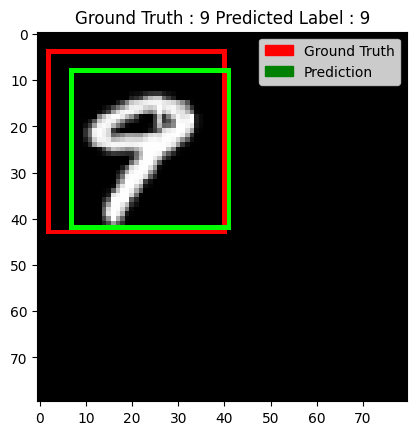

1/1 [==============================] - 0s 13ms/step
32 20 58 46


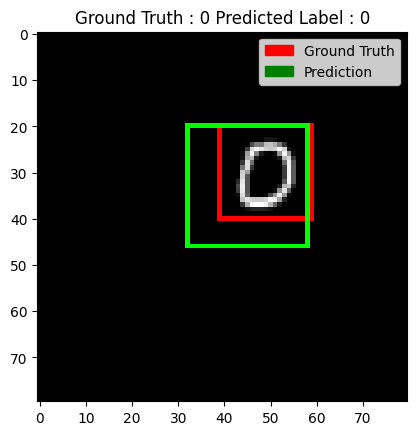

In [47]:
for i in range(10):
    predict_and_plot(1+i,conv_model5)

In [9]:
def convolutional_model6(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    D1 = tf.keras.layers.Dropout(0.2)(C1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    D2 = tf.keras.layers.Dropout(0.2)(C2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    D3 = tf.keras.layers.Dropout(0.2)(C3)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D3)

    C4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(P3)
    D4 = tf.keras.layers.Dropout(0.2)(C4)
    P4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D4)

    C5 = tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(P4)
    D5 = tf.keras.layers.Dropout(0.2)(C5)
    P5 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D5)

    C6 = tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(P5)
    D6 = tf.keras.layers.Dropout(0.2)(C6)
    P6 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D6)
    
    F = tf.keras.layers.Flatten()(P6)

    # localization layers
    l_b1 = tf.keras.layers.Dense(256,activation='relu')(F)
    l_b1_d = tf.keras.layers.Dropout(0.2)(l_b1)

    l_b2 = tf.keras.layers.Dense(128,activation='relu')(l_b1_d)
    l_b2_d = tf.keras.layers.Dropout(0.2)(l_b2)

    l_b3 = tf.keras.layers.Dense(64,activation='relu')(l_b2_d)
    l_b3_d = tf.keras.layers.Dropout(0.2)(l_b3)

    l_b4 = tf.keras.layers.Dense(32,activation='relu')(l_b3_d)
    l_b4_d = tf.keras.layers.Dropout(0.2)(l_b4)
    
    # classfication layers
    c_b1 = tf.keras.layers.Dense(128,activation='relu')(F)
    c_b1_d = tf.keras.layers.Dropout(0.2)(c_b1)

    c_b2 = tf.keras.layers.Dense(64,activation='relu')(c_b1_d)
    c_b2_d = tf.keras.layers.Dropout(0.2)(c_b2)
    
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(l_b4_d)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(c_b2_d)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [10]:
conv_model6 = convolutional_model6((80, 80,1))
conv_model6.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 16)           160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 80, 80, 16)           0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 40, 40, 16)           0         ['dropout[0][0]']             
 D)                                                                                           

In [11]:
history6 = conv_model6.fit(train_dataset, epochs=100, validation_data=test_dataset)

2023-12-21 10:05:54.690369: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1228800000 exceeds 10% of free system memory.


Epoch 1/100


2023-12-21 10:05:56.570412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-21 10:05:57.570287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-21 10:05:59.389547: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4680018780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 10:05:59.389582: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-12-21 10:05:59.400013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-21 10:05:59.528807: I ./tensorflow/compiler/jit/device_compiler.h:186] Compil

750/750 [==============================] - 16s 13ms/step - loss: 1.0988 - bbox_output_loss: 0.0214 - class_output_loss: 1.0774 - bbox_output_accuracy: 0.8161 - class_output_accuracy: 0.5949 - val_loss: 4.7235 - val_bbox_output_loss: 0.0064 - val_class_output_loss: 4.7171 - val_bbox_output_accuracy: 0.9155 - val_class_output_accuracy: 0.1656
Epoch 2/100
750/750 [==============================] - 9s 12ms/step - loss: 0.3223 - bbox_output_loss: 0.0088 - class_output_loss: 0.3135 - bbox_output_accuracy: 0.8734 - class_output_accuracy: 0.9118 - val_loss: 1.1066 - val_bbox_output_loss: 0.0047 - val_class_output_loss: 1.1018 - val_bbox_output_accuracy: 0.9199 - val_class_output_accuracy: 0.6650
Epoch 3/100
750/750 [==============================] - 9s 13ms/step - loss: 0.1749 - bbox_output_loss: 0.0067 - class_output_loss: 0.1681 - bbox_output_accuracy: 0.8870 - class_output_accuracy: 0.9551 - val_loss: 0.5062 - val_bbox_output_loss: 0.0036 - val_class_output_loss: 0.5025 - val_bbox_output_ac

/tmp/ipykernel_4047/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_4047/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_4047/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

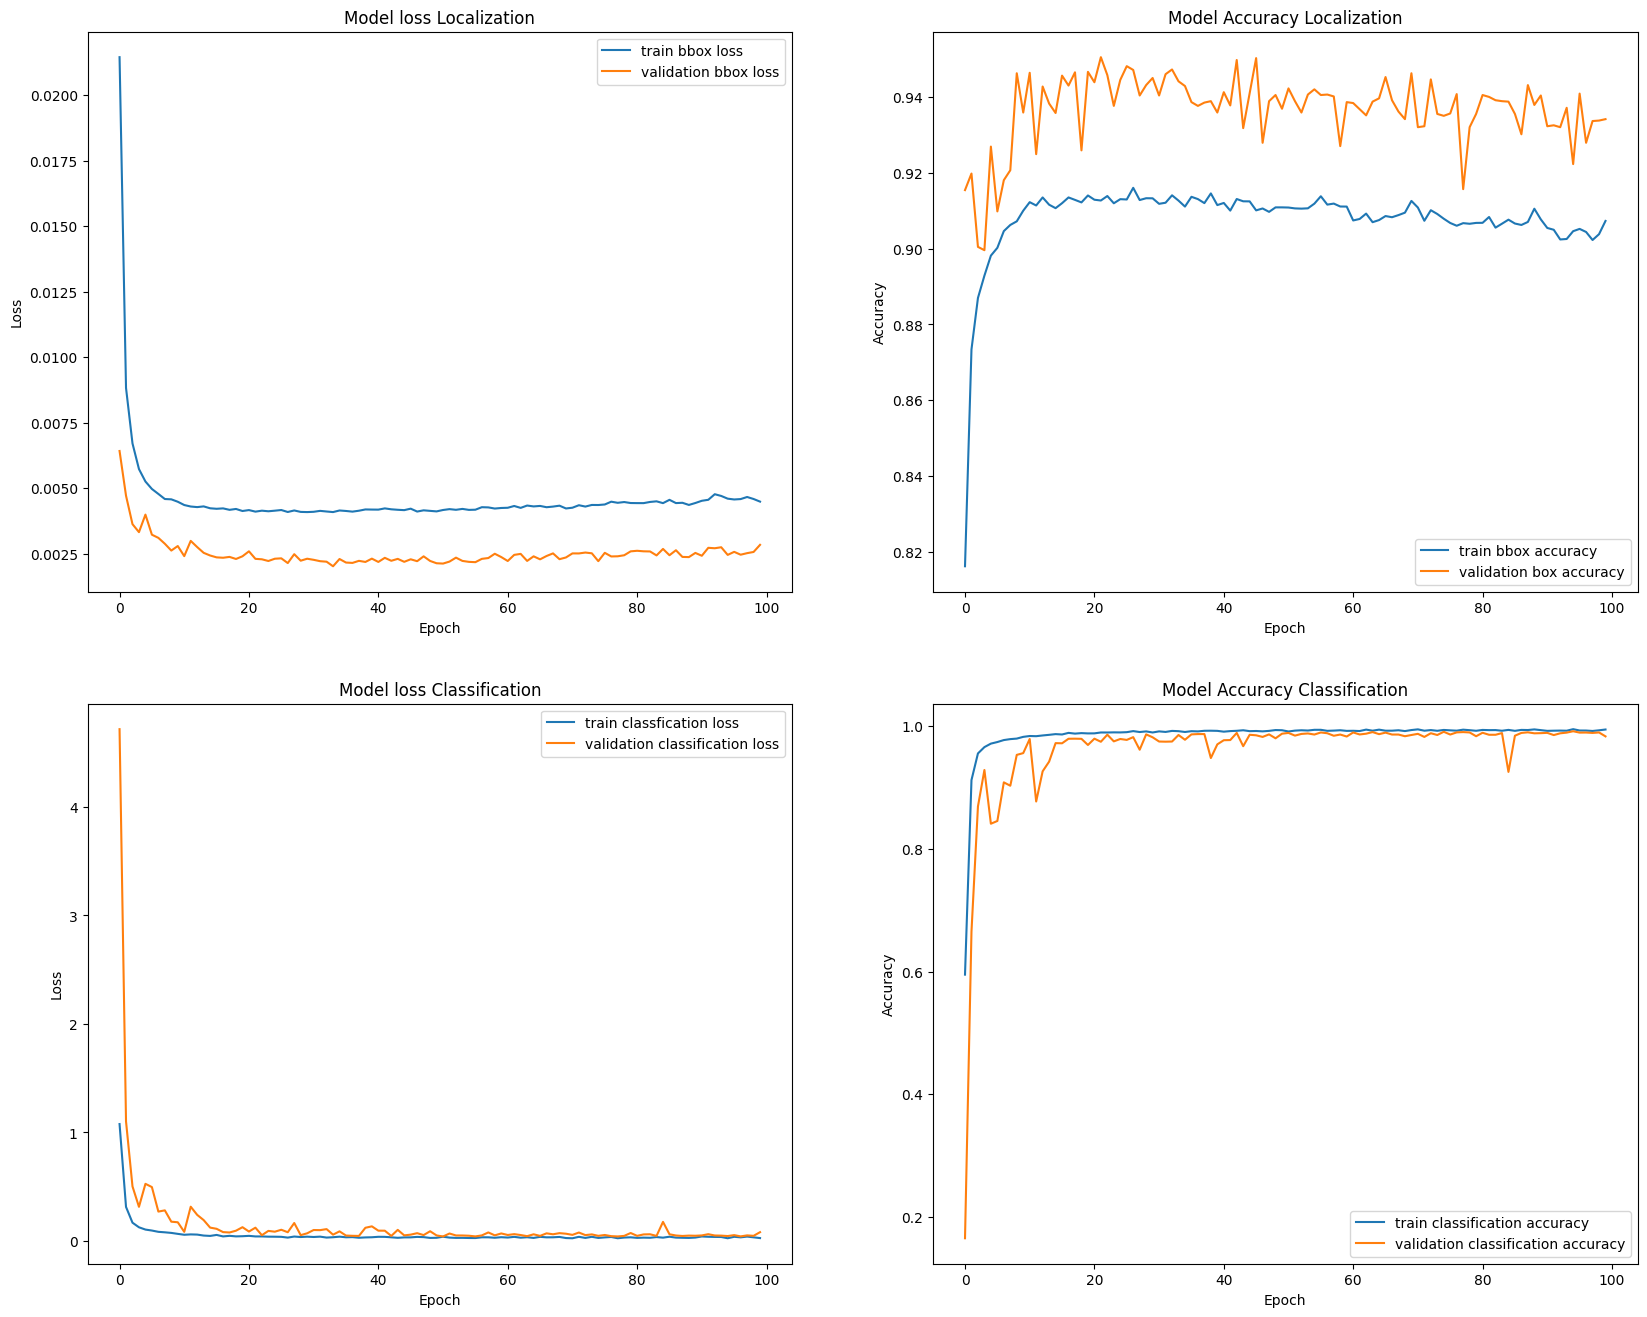

In [16]:
plot_metrics(history6)